### The aim of this project is to build a book recommendation system by using the concept that, books which are similar to each other will be referenced in the articles section(internal wiki links). It also consists of various tools and techniques that can be used to build other types of recommendation system.


# KEY LEARNINGS:

- Importing JSON files
- Dict use just like list comprehension
- Using ITERTOOLS
- Using collections, Counter and Ordereddict
- using various loops within a loop
- Using Generator function to alleviate the need to store all of the training data.


#### Generator function learnings

- Generator function helps to use the function effectively without saving everything to the memory. loop and use yeild
- random class, .sample(population,k), .randrange(int val), .shuffle(list,dict), this library is very effective to randomize process
- Generator needs some type of for, while loop, can just write the code and then say while True
- when we use for loop with i, n enumerate(x), we can still call the i outside the for loop 


#### Words Embedding

- Embedding is used to create a dense vector representing categories/words/sentences/item etc.
- It is a good alternative to one hot encoding. The benefits of embedding is that we can lower the dimensions used and also find cosine similarities between the item.
- Embedding is made easier by using the keras library. 
- When we use the library, It randomly initializes the embedding parameters, which is then trained to find the optimal parameters.
- In this project, the supervised learning is done by creating a pair of positive/negative book and wikilinks.


# Import the libraries 

In [1]:
## Import the libraries 

import pandas as pd
import numpy as np # import array tools
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.layers import Dense, Input, Dot, Reshape, Embedding
from tensorflow.keras.models import Model


from collections import Counter, OrderedDict
from itertools import chain
import json
import random 
random.seed(101) # set random val, to generate same randomness

# Reading the Data

#### The file is already scraped from wikipedia and is saved in JSON format. 

#### Please download the raw file from the github and save in JSON format to call for this project

In [2]:
books = list()

with open('data_set/wiki_books_raw.ndjson', 'r') as fin:
    
    books = [json.loads(l) for l in fin]   # Append, # List comprehension

books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f"There are{len(books)} books.")

There are37020 books.


# Data cleaning and exploration

In [3]:
books[0]

['Freud: His Life and His Mind',
 {'1': '< !-- See Wikipedia:WikiProject_Books -- >',
  'name': 'Freud: His Life and His Mind',
  'image': 'File:Freud, His Life and His Mind (first edition).jpg',
  'caption': 'Cover of the first edition',
  'author': 'Helen Walker Puner',
  'country': 'United States',
  'language': 'English',
  'subject': 'Sigmund Freud',
  'publisher': 'Dell Publishing',
  'pub_date': '1947',
  'media_type': 'Print (Hardcover and Paperback)',
  'pages': '288 (1959 edition)',
  'isbn': '978-1560006114'},
 ['Sigmund Freud',
  'Dell Publishing',
  'Hardcover',
  'Paperback',
  'Sigmund Freud',
  'Erich Fromm',
  'Dell Publishing',
  'Anna Freud',
  'Ernest Jones',
  'Carl Jung',
  'Wilhelm Stekel',
  'Fritz Wittels',
  'Maurice English',
  'The Nation',
  'Frederick Crews',
  'The New York Review of Books',
  'Peter Gay',
  'Freud: A Life for Our Time',
  'The Life and Work of Sigmund Freud',
  'Louis Breger',
  'Wilhelm Fliess',
  'Freud family',
  'Cambridge University

#### It returns a list within a list. the 0 index within the list gives us the book title, 1 index postition gives book into and the 2 index position gives the internal wiki links

# Map books to integers 

#### This step is necessay, as the embedding neural network requires the books to be in integer format. We will also reverse to get index to book

In [4]:
book_index = {book[0]:i for i,book in enumerate(books)}  #Creates a dict of the book title with its index pos as value
index_book = {i: book[0] for i,book in enumerate(books)}

### Explore the wikilinks, # of links, unique links and common links

In [5]:
wikilinks = list(chain(*[book[2] for book in books])) #We can use itertools to combine the list within a list 
print(f"There are {len(wikilinks)} total wikilinks and {len(set(wikilinks))} unique wiki links")

There are 1187773 total wikilinks and 311276 unique wiki links


In [6]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(wikilinks_other_books)} total wikilinks and {len(set(wikilinks_other_books))} unique wiki links")

There are 50407 total wikilinks and 17032 unique wiki links


### Most Linked Articles

#### We want to count the links from each book once, We can take advantage of collections module to pass in a list and give out the sorted counted items in the list as dict

In [7]:
def count_val(listt):  ## Create a function that takes in a list and outputs a dict ordered
    
    counts = Counter(listt) # call Counter object and pass in the list, gives ordered vals.
    
    counts = sorted(counts.items(), key= lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts # returns a dict in ordered format

In [8]:
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_val(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

#### lower case the links to get accurate number of links

In [9]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_val(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

#### We also want to remove the most common links for the ML model

In [10]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

In [11]:
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


#### Most linked to the books

In [12]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_val(unique_wikilinks_books)
list(wikilink_book_counts.items())[0:5]


[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51)]

#### PLOT

Text(0.5, 1.0, 'Most Reapeated book')

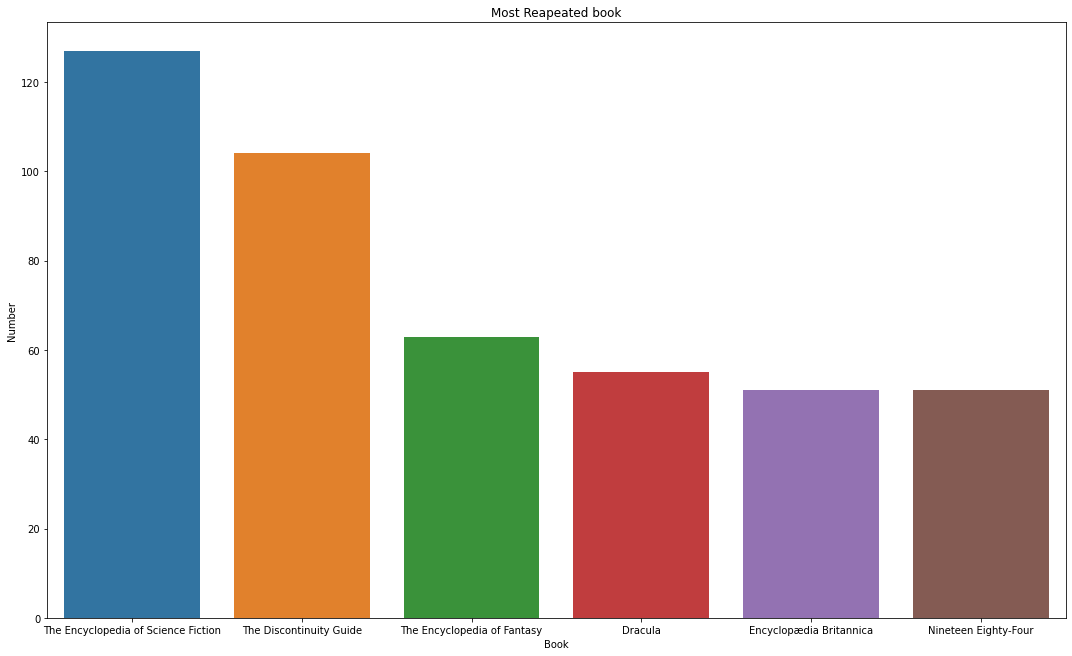

In [13]:
# Plot the most repeated books
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # for Visualization

common_book = pd.DataFrame(list(wikilink_book_counts.items()), columns = ["Book", "Number"])

plt.figure(figsize = (15,9))
sns.barplot(x = "Book", y = "Number", data= common_book[:6])
plt.tight_layout()
plt.title("Most Reapeated book")

#### Wikilinks to Index and vise versa

In [14]:
link_index = {link: i for i, link in enumerate(links)}
index_link = {i: link for link, i in link_index.items()}

# MACHINE LEARNING

#### Basically, we want to create a pair of tuples with each book and its respective wikilinks. This data will be used as a training set in our supervised learning algorithm to find the optimal embeddings.

#### Use Generator to see if the function prints a tules of index, as its a large data set and will take some time to load, generate it and if it works, then you can create a list comprehension for it.


In [15]:
## Creating a function to generate next item, as it does not save in the memory until you call next
## yield to call generator and next to see the next result

def create_pairs(books,links):
    
    for book in books:
        for link in book[2]:
            if link.lower() in links:
                yield((book_index[book[0]], link_index[link.lower()]))

In [16]:
## CHecking if the values are correct
yolo = create_pairs(books,links)

for i in range(10):
    print(next(yolo))

(0, 265)
(0, 353)
(0, 265)
(0, 4515)
(0, 353)
(0, 15961)
(0, 9542)
(0, 1028)
(0, 25616)
(0, 661)


In [17]:
pairs = []

for book in books:
   
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)                   

In [18]:
print(f"pairs: {len(pairs)}, links: {len(links)}, books: {len(books)}")

pairs: 772798, links: 41758, books: 37020


#### S0, We have 772798 pairs of training set

In [19]:
## Some Examples

index_book[pairs[501][0]], index_link[pairs[501][1]]

('Lost in language  &  sound', 'misogynistic')

#### TRAINING SET : Since we are not trying to build a model to predict, we do not need to split our data between training and validation. We want to get the most optimal embedding, so its a better idea to use all the data available for training for better accuracy. 

#### Embedding is just a way to vectorize the words. Just like one hot encoding, we use embedding to get getter vector representation. unlike one hot encoding, embedding is also usefull as it groups similar categories together. We can then take cosine distance (dot product) to get the similarity between two vectors.

In [20]:
pairs_set = set(pairs)

In [21]:
# So, we basically want to create a batch generator that gives the training example in array(batchsize,3)
# which is book_index, link_index and the positive/negative response. 

In [22]:
def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0):
    
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    neg_cl_lab = 0   ## Since we will be using classification, the negative examples will be 0
    
    # Create a Generator.. Basically to be efficient with the memory
    while True:
        # Creates an array from a randomly chosen sample set
        for i, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[i, :] = (book_id, link_id, 1)

        # Increment i by 1 at each loop
        i =i + 1
        
        # Continue to create the batch with negative examples (wikilinks not in book) until the batch size reached
        while i < batch_size:
            
            # random selection of book and link
            r_book = random.randrange(len(books))
            r_link = random.randrange(len(links))
            
            # Check if the combination exists in the positive pair
            if (r_book, r_link) not in pairs_set:
                
                # Add to batch and increment index
                batch[i, :] = (r_book, r_link, neg_cl_lab)
                i =i + 1
                
        # shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

#### Lets see some examples of creating a batch of index and then calling the book, link title out of that index position

In [23]:
combo,y = next(generate_batch(pairs, n_positive=2, negative_ratio=2)) # since it returns a tuple, we assign two variables

for i_book,i_link,i_y in zip(combo["book"],combo["link"],y):
    print(f"Book: {index_book[i_book]:30} link: {index_link[i_link]:30} label: {i_y}")

Book: Like a Conquered Province      link: medieval                       label: 0.0
Book: The Lion (2010 novel)          link: impeachment in the united states label: 0.0
Book: The Princess of Dhagabad       link: herodias                       label: 1.0
Book: Swords Against Darkness        link: category:oxford university press reference books label: 0.0
Book: Between the Bridge and the River link: category:2006 novels           label: 1.0
Book: The Pit (Penswick novel)       link: category:swedish books         label: 0.0


#### The above function takes in pairs of each book with its respective links in tuple type. takes in the number of positive sample you want to generate at a time and also the number of negative result ratio and outputs a array of (book,link,positive/negative) batch thats randomly chosen.

## Steps till now

#### Firstly, We loaded the scraped wikipedia data in JSON format and created a list of all the book info.

#### We then wanted to create a training dataset, which led us to create a book title list and corresponding links list.

#### We then did some cleaning and analysis in order to get better training data for our ML model

#### We then created index for each books and its links, inorder to vectorize it for the ML model

#### We then created a pair of tuples for the indices of books,links

#### We then created a function that generates a batch in the array form, perfect input and output value type for our ML model



# NEURAL NETWORK EMBEDDING MODEL

#### Neural Network Model Using Keras

- When we create a model, it is just the dim,shape and what to use
- layer is just adding the layers, can be Dense layer, Embedding layer, LSTM layer
- activation is adding what function to use to convert the inputs
- compile is used to see how to optimize and the loss func to use to back propagate
- fit is now finally inputs going in the model to find optimal parameters, needs epochs, batch_size etc.

### 
- Usually for embedding, we need: max_vocab_length, max_input_length
- Output shape is 3D tensor (batch_size, input_length, output_dim)
- For more info on embedding, check out the keras- embedding documentation.

In [24]:
def embedding_model(embedding_size = 60):
    
    # Since we will be using functional API to connect the layers in the neural network
    # We create input placeholders of 1D
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])
    
    # book embeddings: It creates 3D output of (book title, integer rep, vector rep)
    # by taking in 2D input (book title, integer rep)
    # output_dim is our choice, basically the number of vec dim rep
    
    # since input_length is 1, we do not need to specify it.
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book) # the (book) is the input value
    
    # Embedding the link of 3D shape
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)
    
    # Dot product the vectors. Output gives 3D, (batch,1,1)
    dot_output = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])
    
    # outputs single number to use loss function
    dot_output = Reshape(target_shape = [1])(dot_output)
    
    # Since we are doing a classification task, we use sigmoid function to convert the vals between 0-1
    dot_output = Dense(1, activation = 'sigmoid')(dot_output)
    
    # Create a neural network model that takes inputs and outputs 
    model = Model(inputs = [book, link], outputs = dot_output)
    
    # we use adam optimizer since it is quicker and binary crossentropy as it is binary task (0,1)
    model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

# Instantiate the model 
model = embedding_model(embedding_size = 40)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
link (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
book_embedding (Embedding)      (None, 1, 40)        1480800     book[0][0]                       
__________________________________________________________________________________________________
link_embedding (Embedding)      (None, 1, 40)        1670320     link[0][0]                       
______________________________________________________________________________________________

2022-06-20 14:13:47.132516: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 14:13:47.133658: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


#### There are nearly 4.0 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data.

# TRAIN MODEL

In [25]:
n_positive = 1150 # number of samples in a batch

generate = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train
recommend = model.fit_generator(generate, epochs = 12, 
                        steps_per_epoch = (len(pairs) // n_positive),
                        verbose = 2)

Epoch 1/12
671/671 - 88s - loss: 0.6629 - accuracy: 0.6244
Epoch 2/12
671/671 - 94s - loss: 0.6390 - accuracy: 0.6667
Epoch 3/12
671/671 - 95s - loss: 0.6368 - accuracy: 0.6667
Epoch 4/12
671/671 - 96s - loss: 0.6365 - accuracy: 0.6667
Epoch 5/12
671/671 - 96s - loss: 0.6365 - accuracy: 0.6667
Epoch 6/12
671/671 - 96s - loss: 0.6365 - accuracy: 0.6667
Epoch 7/12
671/671 - 98s - loss: 0.6365 - accuracy: 0.6667
Epoch 8/12
671/671 - 97s - loss: 0.6365 - accuracy: 0.6667
Epoch 9/12
671/671 - 98s - loss: 0.6365 - accuracy: 0.6667
Epoch 10/12
671/671 - 99s - loss: 0.6365 - accuracy: 0.6667
Epoch 11/12
671/671 - 98s - loss: 0.6365 - accuracy: 0.6667
Epoch 12/12
671/671 - 99s - loss: 0.6365 - accuracy: 0.6667


In [26]:
# Save the model
model.save('book_recommed_wiki_1.h5')

#### Usually we predict new data using our model, but in this project, we just want to use the embedding parameters that we got to find similar books

In [27]:
## Extracting the trained embeddings representing each book

b_layer = model.get_layer("book_embedding") # assigns the layer 
b_weights = b_layer.get_weights()[0]
b_weights.shape # shape = (book title, vec rep of book title)

(37020, 40)

#### The shape above shows that, each book is represented by a 60 dimensional vector. 

#### We now need to normalize the 60d vector. normalizing is the process of finding a unit vector ( with magnitude 1) in the same director as the initial vector that we normalized. This step normalizes all the 37020 vectors, where each vector represents a book. This is done as the dot product of the query book vector and all the other vectors will give the cosine similarity which is used to recommend a book.

In [28]:
b_weights = b_weights / np.linalg.norm(b_weights, axis = 1).reshape((-1, 1)) # Normalizes all the vectors in the array
b_weights[0] ## this array represents the first book in our list which is already normalized

array([ 0.22592951, -0.0582108 ,  0.3083123 , -0.11840917, -0.12364815,
        0.15228452,  0.0852596 , -0.15666091,  0.15261719, -0.0037436 ,
        0.28407413, -0.15441671,  0.09612592, -0.05674679,  0.01238544,
       -0.01603526, -0.13152741, -0.12075199, -0.15884937,  0.09561033,
        0.20556837,  0.13418259, -0.37168857, -0.02439806,  0.08285867,
       -0.18842714,  0.12060835,  0.15655597, -0.30981612, -0.0611244 ,
        0.17117448,  0.08981504,  0.05978707,  0.05466589, -0.11897089,
        0.02789591, -0.01967595, -0.07671958,  0.33723456, -0.01420572],
      dtype=float32)

In [29]:
np.sum(np.square(b_weights[0])) # you can see the magnitude of the vectors is 1 

0.9999999

# FINDING THE SIMILAR BOOKS

#### After we take the dot product, the most similar books are represented with a 1 and the least are represented by -1

In [30]:
# Creates a function that takes the query book name, number of results as n, weights of all the books
# that outputs the books similar or least similar with its correlation value

def similar_books(name, weights, n =5, least_similar = False ):
    
    index = book_index
    r_index = index_book
    
    
    # tries to see if the query book name is amonst the books in our list, if not returns not found
    
    try:
         co_sim = np.dot(weights,weights[index[name]]) # takes cosine similarities between vectors
            
    except KeyError:
        print(f'{name} Not Found.')
        return  
    
    sorted_idx = np.argsort(co_sim) # Sorts the correlation (-1 to 1) in ascending order 
    r_sorted_idx = sorted_idx[::-1] # Sorts the correlation (-1 to 1) in descending order 
    
    if least_similar: # if True
        
        print(f"The least similar books compared to {name} are:")
        print("\n")
        
        for i in range(n):
             print(f"{r_index[sorted_idx[i]]:70} Similarity: {co_sim[sorted_idx[i]]}")
                  
    else:
        print(f"The Most similar books compared to {name} are:")
        print("\n")
        
        for i in range(n):
             print(f"{r_index[r_sorted_idx[i]]:70} Similarity: {co_sim[r_sorted_idx[i]]}")         

# Examples of recommendation

In [31]:
sim_book1 = similar_books(books[0][0],b_weights) # first book in out list of books

The Most similar books compared to Freud: His Life and His Mind are:


Freud: His Life and His Mind                                           Similarity: 0.9999998807907104
Star Trek Lives!                                                       Similarity: 0.5943354368209839
Clouds Blur the Rainbow                                                Similarity: 0.5678695440292358
Culture of Corruption                                                  Similarity: 0.5466879606246948
Drummer Hoff                                                           Similarity: 0.5334361791610718


In [32]:
sim_book2 = similar_books(books[0][0],b_weights,least_similar=True)

The least similar books compared to Freud: His Life and His Mind are:


The Orchid Thief                                                       Similarity: -0.6840913891792297
A Basket of Leaves                                                     Similarity: -0.5944517850875854
Os Maias                                                               Similarity: -0.576063334941864
The 120 Days of Sodom                                                  Similarity: -0.537731945514679
Khalangama Hamala                                                      Similarity: -0.5291274189949036


In [33]:
book3 = books[2][0]  ## assigns the book title

In [34]:
sim_book3 = similar_books(book3,b_weights)

The Most similar books compared to My Real Children are:


My Real Children                                                       Similarity: 1.0
The Age of Louis XIV                                                   Similarity: 0.5981936454772949
Four Upbuilding Discourses, 1844                                       Similarity: 0.5879479050636292
Little People!                                                         Similarity: 0.5691173076629639
The Black Obelisk                                                      Similarity: 0.5546696186065674


#### You can see that the coefficient of similarity is 1 between itself. THAT MAKES SENSE.

### Highlight

For a NLP project, the overall intuition involves:

- tokenizing the words, removing STOPWORDS, stemming
- Creating integer index, converting it to vector (use various libraries for this)
- Embedding the words to get densed vector
- Supervised learning to optimize the embedding parameters
- Converting the vector back to words

# CONCLUSION

We created a pretty decent book recommendation system by following a simple concept that similar books will be referenced in the query book. We then created a neural network to develop a supervised learning to merge books and the referened books in order to get the embedding parameters, which was then used to find the cosine similarities.

The embedding parameters found can be used in various ways to find the similar books. We could also find similar books based on the genre, authors etc. 

### How can we improve 
#### We can improve the model in various ways in order to get better embedding vectors:

- We can clean the dataset further by removing common items in order to reduce the noise
- We can optimize hyper-parameters in the neural network model to get better result
- We can use a different info to do the supervised learning in order to get better model to recommend
- We can try and use regression model instead of classification